In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Data cleansing and EDA

In [4]:
user = pd.read_csv('user_table.csv')
test = pd.read_csv('test_table.csv')
test['ads_channel'] = test['ads_channel'].fillna('Unknown')

In [8]:
user.head()

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia
3,987753,F,27,Venezuela
4,554597,F,20,Spain


In [21]:
data = test.merge(user, how='left', on='user_id')
data['age'] = data['age'].fillna('Unknown')
data['sex'] = data['sex'].fillna('Unknown')
data['country'] = data['country'].fillna('Unknown')

**Other than Spain, which had all users in the control group, the rest of countires should have approximately same proportion of users in the test and control group, however, Argentina and Uruguay had significantly more test users than the control group, this might cause the ananlysis go sideway.**

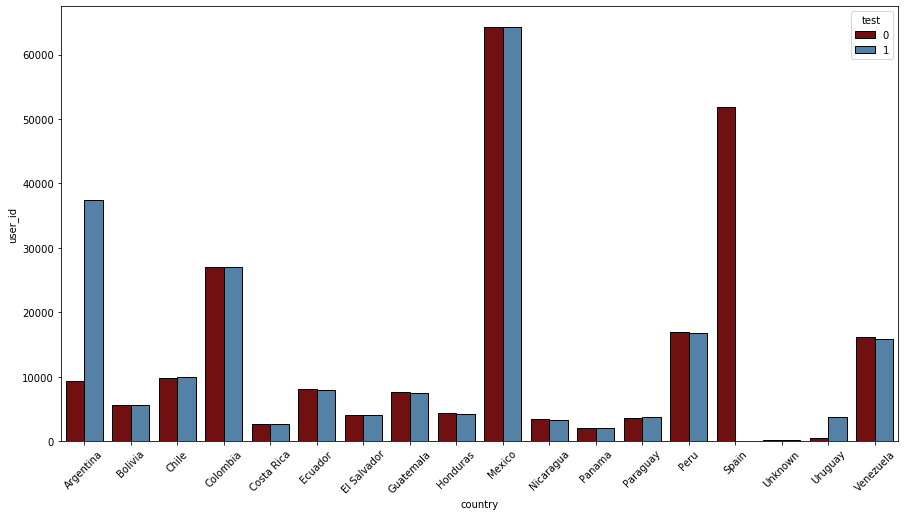

In [105]:
fig, ax = plt.subplots(figsize=(15, 8))
groups = data.pivot_table(index=['country','test'], aggfunc={'user_id': 'count'})
groups = groups.reset_index()
sns.barplot(data=groups, x='country', y='user_id', hue='test', edgecolor='black', palette=['maroon', 'steelblue'])
plt.xticks(rotation=45);

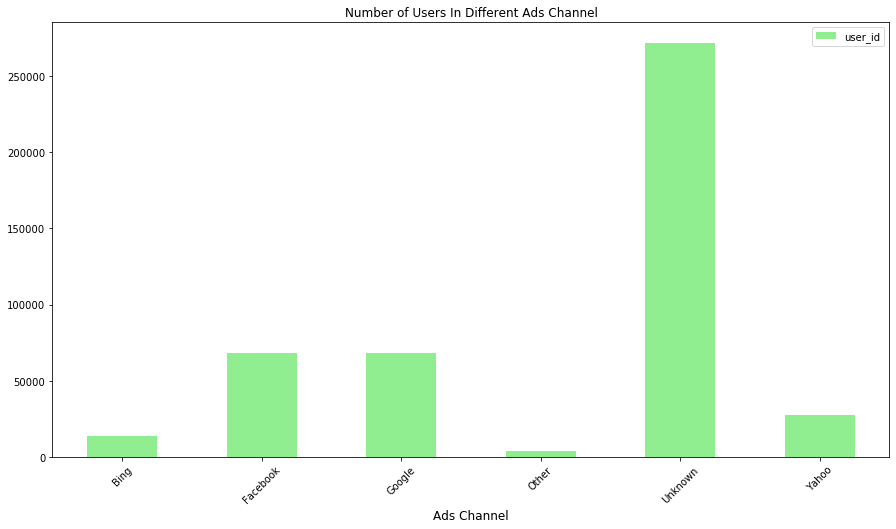

In [121]:
fig, ax = plt.subplots(figsize=(15, 8))
data.groupby('ads_channel').agg({"user_id": 'count'}).plot(kind='bar', ax=ax, color='lightgreen')
plt.xticks(rotation=45)
plt.xlabel('Ads Channel', fontsize=12)
plt.title("Number of Users In Different Ads Channel", fontsize=12);

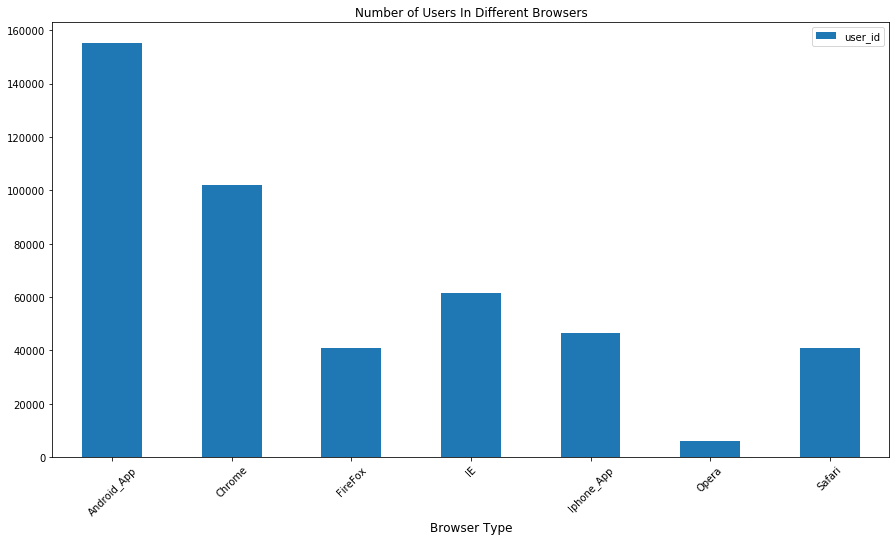

In [118]:
fig, ax = plt.subplots(figsize=(15, 8))
data.groupby('browser').agg({"user_id": 'count'}).plot(kind='bar', ax=ax)
plt.xticks(rotation=45)
plt.xlabel('Browser Type', fontsize=12)
plt.title("Number of Users In Different Browsers", fontsize=12);

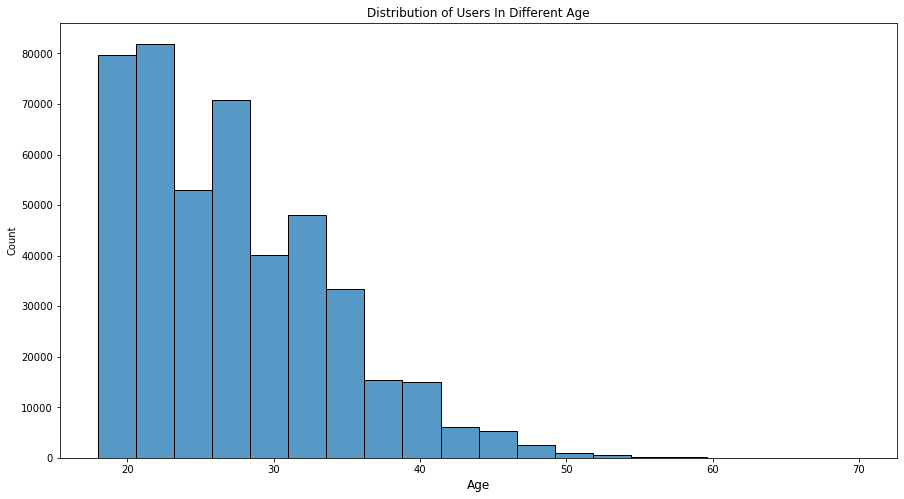

In [152]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.histplot(data.loc[data['age']!='Unknown', 'age'], edgecolor='black', ax=ax, bins=20)
plt.xlabel('Age', fontsize=12)
plt.title("Distribution of Users In Different Age", fontsize=12);

# Question one

**The overall mean conversion rate of the control group was higher than the test group. However, we need to conduct a statistical hypothesis to draw the conclusion. Since there are only two options of this event, either convert or not, then it is a Bernoulli trial, let us assume that the probability of a user successfully converted is the same, this is a solid assumption because even though each user is intrinsically different, but for the group overall, the conversion rate is relatively stable, especially when the sample size is large, which is true in this case.**

In [245]:
data.groupby('test').agg({"conversion": lambda x: sum(x)/len(x)})

,conversion
test,
0,0.055179
1,0.043425


**Since both population follow a Bernoulli distribution, we can conduct a two Sample Z Proportion Hypothesis Test to verify if the conversion rate of control group is significantly better than the test group.**

**The statistics for this test is $ Z= \frac{\hat P_{1}-\hat P_{2}-0}{\sqrt{P_{0}(1-P_{0})(\frac{1}{n_{1}}+\frac{1}{n_{2}})}}$**

**Where${P_{1}}$ and ${P_{2}}$ are the conversion rate of those two sub samples and ${P_{0}}$is the mean of all samples.**

- **Null hypothesis: Two samples have the same conversion rate**
- **Alternative hypothesis: Two samples do not have the same conversion rate**

In [246]:
n1 = len(data[data.test==0])
n2 = len(data[data.test==1])
p1 = len(data[(data.test==0)&(data.conversion==1)]) / n1
p2 = len(data[(data.test==1)&(data.conversion==1)]) / n2
p0 = len(data[(data.conversion==1)]) / len(data)

In [247]:
print("n1: ", n1)
print("n2: ", n2)
print("p1: ", p1)
print("p2: ", p2)
print("p0: ", p0)

n1:  237338
n2:  215983
p1:  0.055178690306651276
p2:  0.043424713982118966
p0:  0.04957855471067963


- $\hat P_{1} = 0.055178690306651276$
- $\hat P_{2} = 0.043424713982118966$
- $\hat P_{0} = 0.04957855471067963$
- $n_{1} = 237338$
- $n_{2} = 215983$

In [248]:
Z = (p1-p2)/np.sqrt(p0*(1-p0)*(1/n1+1/n2))
Z

18.20833653382862

In [250]:
Z = (p1-p2-0.01)/np.sqrt(p0*(1-p0)*(1/n1+1/n2))
Z

2.7171223003737737

**Since the Z statistics is 7.40 greather than the 5% confidence interval(1.96), we can reject the null hypothesis. In fact we can also reject the hypothesis of $P_{1}$ and $P_{1}$ are less than 1% of difference. Therefore, we are statistically confident to claim that the control group performed better than the test group.**

# Question two

In [211]:
def two_sample_test(sample, difference=0):
    
    n1 = len(sample[sample.test==0])
    n2 = len(sample[sample.test==1])
    p1 = len(sample[(sample.test==0)&(sample.conversion==1)]) / n1
    p2 = len(sample[(sample.test==1)&(sample.conversion==1)]) / n2
    p0 = len(sample[(sample.conversion==1)]) / len(sample)
    
    Z = (p1-p2-difference)/np.sqrt(p0*(1-p0)*(1/n1+1/n2))
    
    if Z >= 1.96:
        print(f"Z={Z}, reject null hypothesis")
    else:
        print(f"Z={Z}, fail to Reject null hypothesis")
        
    return Z

**Test for different countries:**

In [232]:
countries = data_without_spain['country'].unique()

In [235]:
country_list = []
Z_list = []
for country in countries:
    s = data[data.country==country]
    country_list.append(country)
    z = two_sample_test(s, 0)
    Z_list.append(z)
    
country_test = pd.DataFrame(data={'country': country_list, 'Z_score': Z_list})
country_test['result'] = country_test['Z_score'].apply(lambda x: "Reject" if x >= 1.96 else "Fail to reject")

Z=-1.3866626773050972, fail to Reject null hypothesis
Z=0.5625732259681572, fail to Reject null hypothesis
Z=0.3599995702246897, fail to Reject null hypothesis
Z=0.7999778275743052, fail to Reject null hypothesis
Z=-0.14744931003959355, fail to Reject null hypothesis
Z=1.1547382454484054, fail to Reject null hypothesis
Z=-0.2789128647053773, fail to Reject null hypothesis
Z=-0.289835864365973, fail to Reject null hypothesis
Z=-0.401848489206088, fail to Reject null hypothesis
Z=-1.030348169321816, fail to Reject null hypothesis
Z=0.9908559056894923, fail to Reject null hypothesis
Z=0.04825960077559222, fail to Reject null hypothesis
Z=0.5649098718449432, fail to Reject null hypothesis
Z=0.7197755576498536, fail to Reject null hypothesis
Z=-0.14630297987487037, fail to Reject null hypothesis
Z=-0.3782096988522646, fail to Reject null hypothesis
Z=0.8477725996152539, fail to Reject null hypothesis


In [236]:
country_test

,country,Z_score,result
0,Mexico,-1.386663,Fail to reject
1,Venezuela,0.562573,Fail to reject
2,Bolivia,0.360000,Fail to reject
3,Colombia,0.799978,Fail to reject
4,Uruguay,-0.147449,Fail to reject
5,El Salvador,1.154738,Fail to reject
6,Nicaragua,-0.278913,Fail to reject
7,Peru,-0.289836,Fail to reject
8,Costa Rica,-0.401848,Fail to reject
9,Chile,-1.030348,Fail to reject


**We can see that although all countries collectively showed a significant difference in the test and control group, individually, none of them rejected the null hypothesis.One caveat of our first testing was that Spain was included, where no test group was in it.If we remove it from the data, we can still reject the null hypothesis but the Z statistics is much smaller now.**

In [251]:
data_without_spain = data[data.country != 'Spain']

In [253]:
two_sample_test(data_without_spain, 0)

Z=7.422021422012666, reject null hypothesis


7.422021422012666

**Previously, we noticed that the sizes of control and test group for Argentina unproportionate, this might be problematic as the idea of sampling is to make sure the sample represent the population and one sample size that is significantly larger than the other one will possibly create bias. In fact, when we remove Spain and Argentina from the data set, we failed to reject the hypothesis that two samples have different conversion rate.**

In [252]:
data_without_spain_argentina = data_without_spain[data_without_spain.country != 'Argentina']

In [254]:
two_sample_test(data_without_spain_argentina, 0)

Z=0.6245838176510832, fail to Reject null hypothesis


0.6245838176510832